In [244]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [245]:
!pip install cmdstanpy==1.0.1
!pip install pystan==2.18.0.0
!pip install fbprophet==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-1.0.1-py3-none-any.whl (69 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.6 requires cmdstanpy==0.4, but you have cmdstanpy 1.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-0.4.0-py3-none-any.whl (22 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.1
    Uninstalling cmdstanpy-1.0.1:
      Successfully uninstalled cmdstanpy-1.0

### Load The Relevant Libraries

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

### Loading the Dataset

In [247]:
df = pd.read_csv('/content/drive/MyDrive/Stage_E_Quiz_Data.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [248]:
df.shape

(92016, 5)

In [249]:
# No Missing Values
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

#### Changing Some Columns

 Using the FullDate column as (‘dt’ or ‘ds’) and ElecPrice as ( ‘y’). Answer question 14 - 16

 I'll be using Ds for FullDate Due to the error I got when using the Facebook prophet to train the data

In [250]:
# Convert the FullDate column to DateTime
df['FullDate']= pd.to_datetime(df['FullDate'])

# Rename the Columns FullDate And ElecPrice
df = df.rename(columns={"FullDate" : "ds" , "ElecPrice" : "y" }) 
df.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


#### Creating a Daily Sample Rate

Using DS

In [251]:
# Resampling from Hourly to Daily Sample Rate
# Daily Sample rate sum
df.set_index( "ds", inplace= True) 
df_daily_rate = df.resample('D').sum()

In [252]:
# Looking at the shape of Daily Rate
df_daily_rate.shape

(3834, 4)

### Splitting the Data Into Train and Test

The first 2757 days is our train set and the last (x-2757) days is our test set

In [253]:
# Initially reseting the index
df_daily_rate.reset_index(inplace=True)
train = df_daily_rate.iloc[:2757,:]
test = df_daily_rate.iloc[2757:,:]

#### Confirming the Shape of our Splits

In [254]:
train.shape

(2757, 5)

In [255]:
test.shape

(1077, 5)

### 11  Which of the following is a plot of ElecPrice over time?

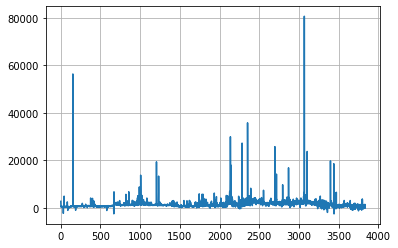

In [256]:
df_daily_rate.y.plot()
plt.grid()

###  12  Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?

In [257]:
# Importing the ADF adfuller library
from statsmodels.tsa.stattools import adfuller 
pv_sysload = adfuller(df_daily_rate['SysLoad'])
pv_gasprice = adfuller(df_daily_rate['GasPrice']) 
round(pv_sysload[1],6), round(pv_gasprice[1],6)

(0.004254, 0.045027)

### 13  Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?¶

In [258]:
cv_elecprice = adfuller(df_daily_rate['y'])
round(pv_gasprice[4]['10%'],4), round(cv_elecprice[4]['5%'],4)

(-2.5672, -2.8623)

### 14  Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [259]:
# Defining a Function for MAPE
import numpy as np

def mape(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.mean(np.abs((y - yhat)/y)*100),2)

In [260]:
model_1 = Prophet() 
model_1.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [261]:
pred_1 = model_1.predict(test) 
mape(test['y'],pred_1['yhat'])

546.05

### 15  What is the RMSE in 2 decimal places?

In [262]:
def rmse(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.sqrt(np.mean(np.square(y - yhat))),2)

# evaluate rmse
rmse(test['y'],forecast_1['yhat'])

3211.03

### 16  If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?

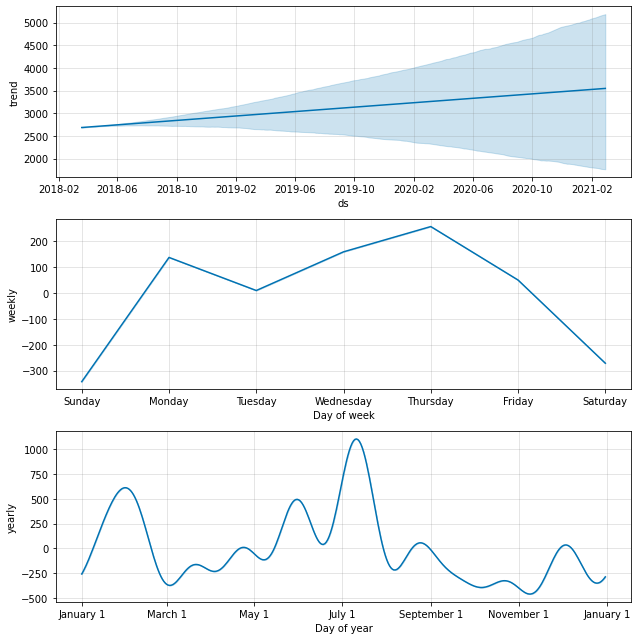

In [263]:
model_1.plot_components(pred_1) 
plt.show()

July as Seen in the Yearly Plot

### Multivariate Time Series Forecasting with Facebook Prophet For 17 - 19


These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors

In [264]:
model_2 = Prophet()
model_2.add_regressor('SysLoad')
model_2.add_regressor('Tmax')
model_2.add_regressor('GasPrice')
model_2.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 17  Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [265]:
pred_2 = model_2.predict(test) 
mape(test['y'],pred_2['yhat'])

234.08

### 18 What is the RMSE in 2 decimal places?¶

In [266]:
rmse(test['y'],forecast_2['yhat'])

2709.96

### 19  If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?

Options

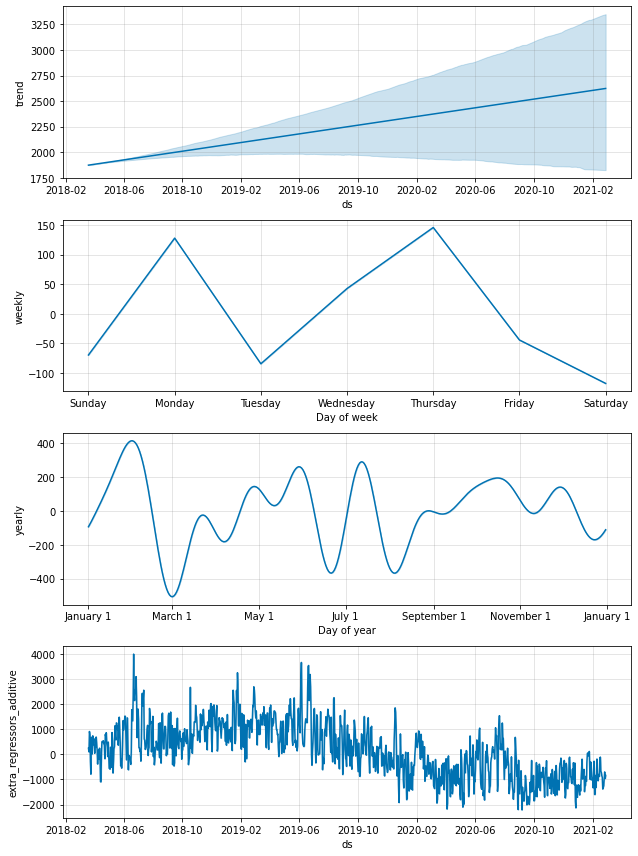

In [267]:
model_2.plot_components(pred_2) 
plt.show()

Thursday from the weekly plot

### Training a forecast model without 'Tmax' For Question 20

In [268]:
model_3 = Prophet()
model_3.add_regressor('SysLoad')
model_3.add_regressor('GasPrice')
model_3.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 20  What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set

In [243]:
pred_3 = model_3.predict(test) 
mape(test['y'],pred_3['yhat'])

230.19